<a href="https://colab.research.google.com/github/Snehithakatha/garbagecollection/blob/main/WEEK_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

dataset_dir = '/content/drive/MyDrive/TrashType_Image_Dataset'
image_size = (256, 256)
batch_size = 32
seed = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

Found 18 files belonging to 1 classes.
Using 15 files for training.
Found 18 files belonging to 1 classes.
Using 3 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['plastic']


In [6]:
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
split_index = max(1, val_batches // 2)
test_ds = val_ds.take(split_index)
val_ds = val_ds.skip(split_index)

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())

class_weight_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = {i: w for i, w in enumerate(class_weight_array)}
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0)}


In [8]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2)
])

In [9]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(256, 256, 3),
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [11]:
log_dir = "/content/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)


In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[tensorboard_callback]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/20
1/1 ━━━━━━━━━━━━━

In [13]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Test Accuracy: 0.00%


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (3, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


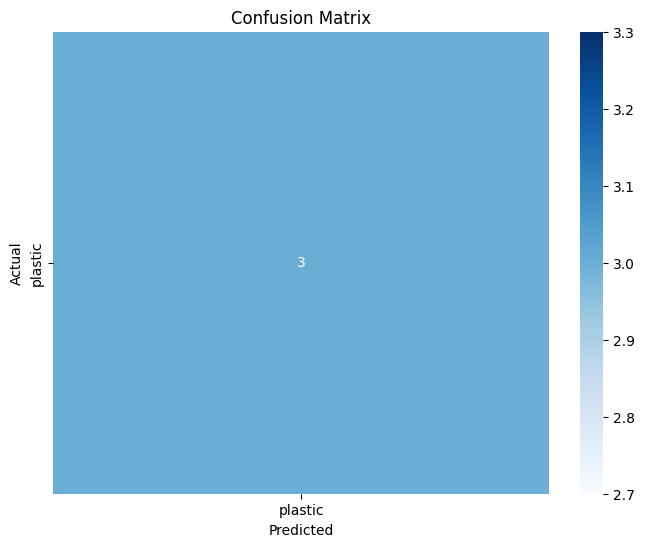

              precision    recall  f1-score   support

     plastic       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [14]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

In [15]:
import cv2

def get_img_array(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=image_size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0


In [16]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [25]:
from tensorflow import keras
from tensorflow.keras import layers


In [26]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)
base_model.trainable = False

model = keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])


In [33]:
for i, layer in enumerate(base_model.layers):
    shape = getattr(layer, 'output_shape', None)
    if shape is None and hasattr(layer, 'batch_input_shape'):
        shape = layer.batch_input_shape
    print(i, layer.name, shape)


0 input_layer_4 None
1 rescaling_3 None
2 normalization_2 None
3 stem_conv None
4 stem_bn None
5 stem_activation None
6 block1a_project_conv None
7 block1a_project_bn None
8 block1a_project_activation None
9 block2a_expand_conv None
10 block2a_expand_bn None
11 block2a_expand_activation None
12 block2a_project_conv None
13 block2a_project_bn None
14 block2b_expand_conv None
15 block2b_expand_bn None
16 block2b_expand_activation None
17 block2b_project_conv None
18 block2b_project_bn None
19 block2b_drop None
20 block2b_add None
21 block3a_expand_conv None
22 block3a_expand_bn None
23 block3a_expand_activation None
24 block3a_project_conv None
25 block3a_project_bn None
26 block3b_expand_conv None
27 block3b_expand_bn None
28 block3b_expand_activation None
29 block3b_project_conv None
30 block3b_project_bn None
31 block3b_drop None
32 block3b_add None
33 block4a_expand_conv None
34 block4a_expand_bn None
35 block4a_expand_activation None
36 block4a_dwconv2 None
37 block4a_bn None
38 blo

In [34]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # The full model contains base_model as the 3rd layer (index 2)
    base_model = model.layers[2]
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    # Build a model that maps input -> conv outputs + final predictions
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_img_array(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=image_size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0


In [36]:
import random
import os

test_image_path = random.choice([
    os.path.join(dataset_dir, class_name, fname)
    for class_name in class_names
    for fname in os.listdir(os.path.join(dataset_dir, class_name))
])
print("Test image:", test_image_path)


Test image: /content/drive/MyDrive/TrashType_Image_Dataset/plastic/plastic_006.jpg


In [38]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))


0 rescaling_4 <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
1 efficientnetv2-b0 <class 'keras.src.models.functional.Functional'>
2 global_average_pooling2d_1 <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
3 dropout_1 <class 'keras.src.layers.regularization.dropout.Dropout'>
4 dense_1 <class 'keras.src.layers.core.dense.Dense'>


In [42]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.layers[1]  # index 1 is your EfficientNet base
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [46]:
_ = model(img_array)  # Forward pass to build the model


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [48]:
layers.Dense(num_classes, activation='softmax')


<Dense name=dense_2, built=False>

In [49]:
dummy_input = tf.random.normal([1, 256, 256, 3])  # Batch size 1, same size as your input
_ = model(dummy_input)


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [50]:
print(model.layers[-1])  # or whichever layer is dense_2


<Dense name=dense_1, built=True>


In [57]:
_ = model(img_array)


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [58]:
print(f"Number of classes: {num_classes}")
print(model.layers[-1].units)


Number of classes: 1
1


In [59]:
import os

dataset_dir = '/content/drive/MyDrive/TrashType_Image_Dataset'
print("Classes found:")
print(os.listdir(dataset_dir))


Classes found:
['.DS_Store', 'plastic']


In [61]:
!find /content/drive/MyDrive/TrashType_Image_Dataset -name ".DS_Store" -delete


In [62]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)
print("Num classes:", len(class_names))


Found 18 files belonging to 1 classes.
Using 15 files for training.
Found 18 files belonging to 1 classes.
Using 3 files for validation.
Classes: ['plastic']
Num classes: 1


In [64]:
import os

dataset_dir = '/content/drive/MyDrive/TrashType_Image_Dataset'

# List all subfolders (classes)
classes = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
print("Classes found:", classes)

# List contents of each class folder (first 5 files to avoid too much output)
for c in classes:
    class_path = os.path.join(dataset_dir, c)
    files = os.listdir(class_path)[:5]
    print(f"Class '{c}' samples:", files)


Classes found: ['plastic']
Class 'plastic' samples: ['plastic_003.jpg', 'plastic_012.jpg', 'plastic_006.jpg', 'plastic_007.jpg', 'plastic_004.jpg']


In [69]:
import tensorflow as tf

img_height = 224
img_width = 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)


Found 64 files belonging to 6 classes.
Using 52 files for training.
Found 64 files belonging to 6 classes.
Using 12 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [70]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [68]:
!ls -R /content/drive/MyDrive/TrashType_Image_Dataset


/content/drive/MyDrive/TrashType_Image_Dataset:
cardboard  glass  metal  paper	plastic

/content/drive/MyDrive/TrashType_Image_Dataset/cardboard:
 360_F_816911064_Ak4KB6cng9WKvzCr3HP49PnOiq3g0Kkd.jpg
 cardboard-waste-EG82M8.jpg
 cardboard-waste-paper-500x500.webp
 cardboard-waste-recycling.jpg
'images (1).jpeg'
'images copy.jpeg'
 images.jpeg
 istockphoto-148074133-612x612.jpg
 Paper-and-Cardboard-Waste465x465.webp
 Why-is-cardboard-waste-a-problem-featured.webp

/content/drive/MyDrive/TrashType_Image_Dataset/glass:
'64437d16353df8e86c183658_sec-1 img-1.png'
 glass-recycling.jpg
'images (1).jpeg'
'images (2).jpeg'
'images (3).jpeg'
'images (4).jpeg'
 images.jpeg
 iStock-1081866910.jpg
 RR-Blog-Why-Glass-Recycling-Going-Away.webp
 Untitled-design-13-1.jpg
 Waste-Glass.jpg

/content/drive/MyDrive/TrashType_Image_Dataset/metal:
 Depositphotos_40012335_xl-2015_optimized.jpg
'images (1).jpeg'
'images (2).jpeg'
'images (3).jpeg'
'images (4).jpeg'
'images (5).jpeg'
'images (6).jpeg'
'images (

In [71]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0

num_classes = len(class_names)

base_model = EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,926,998 (22.61 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [72]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - accuracy: 0.1651 - loss: 1.8264 - val_accuracy: 0.0000e+00 - val_loss: 1.9156
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1955 - loss: 1.7327 - val_accuracy: 0.2500 - val_loss: 1.9618
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1955 - loss: 1.7243 - val_accuracy: 0.2500 - val_loss: 2.0293
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2965 - loss: 1.7420 - val_accuracy: 0.2500 - val_loss: 2.0596
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3173 - loss: 1.7130 - val_accuracy: 0.2500 - val_loss: 2.0529
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2756 - loss: 1.7905 - val_accuracy: 0.2500 - val_loss: 2.0144
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2965 - loss: 1.6838 - val_accuracy: 0.2500 - val_loss: 1.9877
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2756 - loss: 1.7468 - val_accuracy: 0.2500 - val_loss: 1.9570
Epoch 9/10

In [74]:
model.save('/content/garbage_classifier_model.keras')

model.export('/content/garbage_classifier_saved_model')

import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/garbage_classifier_saved_model')
tflite_model = converter.convert()

with open('/content/garbage_classifier_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/content/garbage_classifier_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1368')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138503079580048: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138503079578896: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138503079576592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138503079577744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138503079584848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138503079586192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138503079577360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138503079582352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138503079584464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138503079580240: TensorSpec(shape=(), 

In [75]:
interpreter = tf.lite.Interpreter(model_path='/content/garbage_classifier_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)


Input details: [{'name': 'serving_default_keras_tensor_1368:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 531, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


Predicted output: [[0.11409366 0.1894397  0.17017008 0.07615648 0.25791925 0.19222079]]


In [77]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc * 100:.2f}%")


Found 64 files belonging to 6 classes.
Using 12 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.9286
Test Accuracy: 25.00%


In [83]:
test_dir = '/content/drive/MyDrive/TrashType_Image_Dataset'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),  # Ensure this matches your model's input
    batch_size=32,
    shuffle=False
)


Found 64 files belonging to 6 classes.


In [89]:
!pip install split-folders


In [90]:
import splitfolders

# Replace with your actual path
input_folder = '/content/drive/MyDrive/TrashType_Image_Dataset'
output_folder = '/content/drive/MyDrive/TrashType_Split'

# Split: 70% train, 15% val, 15% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))


Copying files: 73 files [00:06, 11.92 files/s]


Found 44 files belonging to 6 classes.
Found 6 files belonging to 6 classes.
Found 14 files belonging to 6 classes.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class Weights: {0: np.float64(1.2222222222222223), 1: np.float64(1.0476190476190477), 2: np.float64(1.0476190476190477), 3: np.float64(1.4666666666666666), 4: np.float64(0.6111111111111112), 5: np.float64(1.0476190476190477)}
35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,769,374 (33.45 MB)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.0919 - loss: 1.8398 - val_accuracy: 0.1667 - val_loss: 1.8043
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.1686 - loss: 1.8416 - val_accuracy: 0.1667 - val_loss: 1.7944
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.1534 - loss: 1.7901 - val_accuracy: 0.3333 - val_loss: 1.7488
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 611ms/step - accuracy: 0.1837 - loss: 1.8160 - val_accuracy: 0.3333 - val_loss: 1.7498
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 624ms/step - accuracy: 0.2453 - loss: 1.8253 - val_accuracy: 0.5000 - val_loss: 1.7592
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.1534 - loss: 1.8252 - val_accuracy: 0.1667 - val_loss: 1.7941


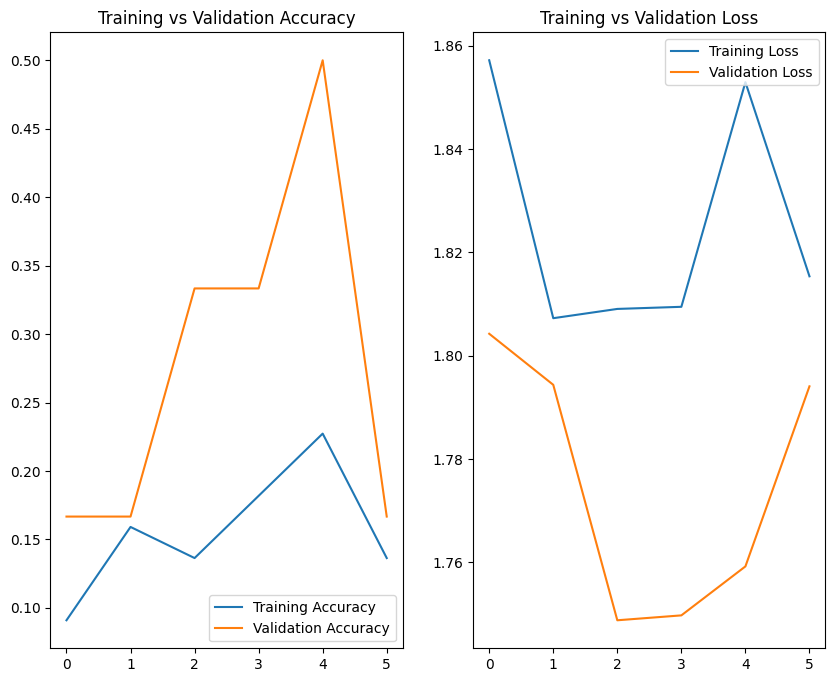

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - accuracy: 0.2857 - loss: 1.7582
Test accuracy: 0.2857, Test loss: 1.7582
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[0 0 0 0 1 0]
 [0 0 0 0 2 0]
 [0 0 0 0 3 0]
 [0 0 0 0 2 0]
 [0 0 0 0 4 0]
 [0 0 0 0 2 0]]
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00         1
       glass       0.00      0.00      0.00         2
       metal       0.00      0.00      0.00         3
       paper       0.00      0.00      0.00         2
     plastic       0.29      1.00      0.44         4
       trash       0.00      0.00      0.00         2

    accuracy                           0.29        14
   macro avg       0.05      0.17      0.07        14
weighted avg       0.08      0.29      0.13        14



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


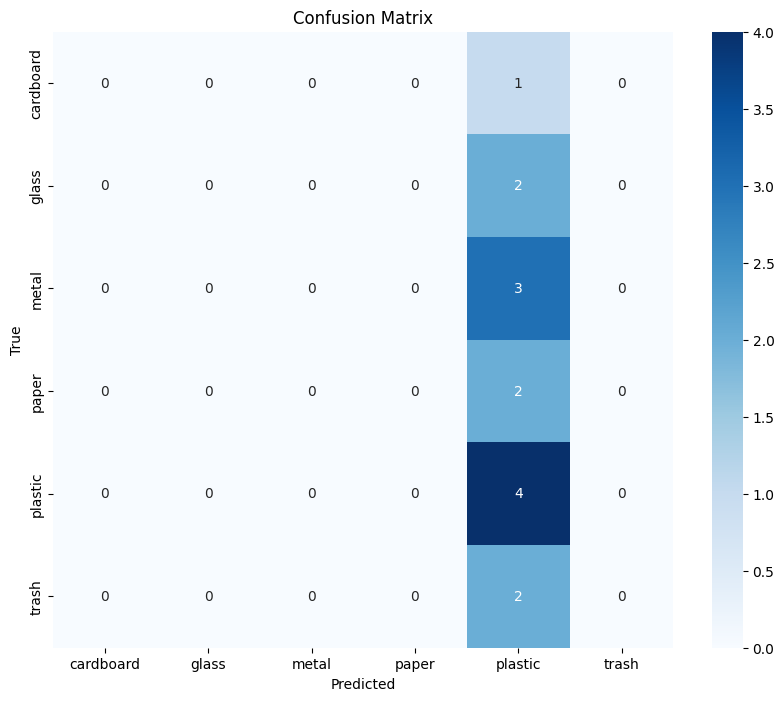

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://11e1e91c7a01c306ff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input

# Define dataset paths
dataset_path = '/content/drive/MyDrive/TrashType_Split'

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path + '/train',
    image_size=(124, 124),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path + '/val',
    image_size=(124, 124),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path + '/test',
    image_size=(124, 124),
    batch_size=32,
    shuffle=False
)

# Extract class names
class_names = train_ds.class_names
print("Class Names:", class_names)

# Class weights for imbalance handling
all_labels = np.concatenate([labels.numpy() for _, labels in train_ds], axis=0)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}
print("Class Weights:", class_weights)

# Data Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Build model using Transfer Learning
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3), weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Early stopping callback
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early]
)

# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

# Evaluate on test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy:.4f}, Test loss: {loss:.4f}')

# Confusion Matrix and Classification Report
y_true = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save model
model.save('/content/EfficientNetV2B2_Trash.keras')

# Gradio Interface for real-time image prediction
model = tf.keras.models.load_model('/content/EfficientNetV2B2_Trash.keras')

def classify_image(img):
    img = img.resize((124, 124))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

iface = gr.Interface(fn=classify_image, inputs=gr.Image(type="pil"), outputs="text")
iface.launch(debug=True)
